#### Checking accidents only in Winters and Prediction

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats

from subprocess import check_output

# Any results you write to the current directory are saved as output.
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

In [2]:
data = pd.read_csv('full_data_with_dates.csv')

In [3]:
small_data = data[['Date', 'Month', 'Number_of_Casualties']]

In [4]:
small_data['convert_to_date'] = pd.to_datetime(small_data['Date'])

In [6]:
small_data = small_data[['convert_to_date','Number_of_Casualties']]

In [10]:
small_data.set_index('convert_to_date', inplace=True)

In [51]:
new_data = small_data.resample('M').sum()

In [64]:
ts = new_data['Number_of_Casualties']
ts_log = np.log(ts)

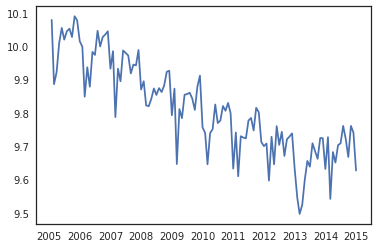

In [65]:
plt.plot(ts_log)

Moving average

In [116]:
len(ts_log)

120

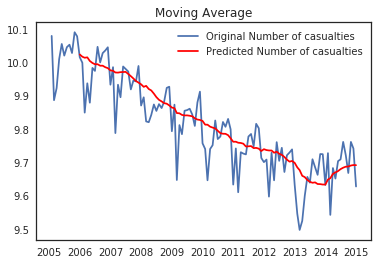

In [129]:
moving_avg = pd.rolling_mean(ts_log, 12)
plt.plot(ts_log, label='Original Number of casualties')
plt.plot(moving_avg, color='red', label='Predicted Number of casualties')
plt.title('Moving Average')
plt.legend()

In [68]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

convert_to_date
2005-01-31         NaN
2005-02-28         NaN
2005-03-31         NaN
2005-04-30         NaN
2005-05-31         NaN
2005-06-30         NaN
2005-07-31         NaN
2005-08-31         NaN
2005-09-30         NaN
2005-10-31         NaN
2005-11-30         NaN
2005-12-31   -0.008245
Freq: M, Name: Number_of_Casualties, dtype: float64

In [72]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

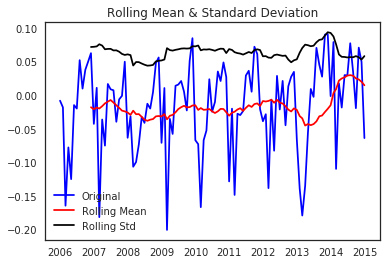

Results of Dickey-Fuller Test:
Test Statistic                 -1.568879
p-value                         0.499205
#Lags Used                     12.000000
Number of Observations Used    96.000000
Critical Value (10%)           -2.583100
Critical Value (5%)            -2.892152
Critical Value (1%)            -3.500379
dtype: float64


In [73]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

Exponentially Weighted Moving Average

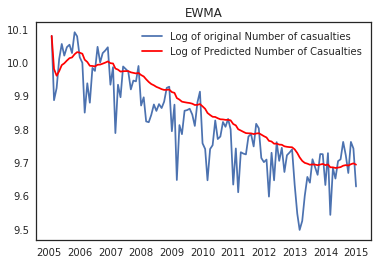

In [126]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log, label='Log of original Number of casualties')
plt.plot(expwighted_avg, color='red', label='Log of Predicted Number of Casualties')
plt.title('EWMA')
plt.legend()

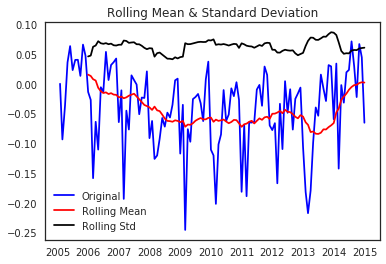

Results of Dickey-Fuller Test:
Test Statistic                  -1.966420
p-value                          0.301488
#Lags Used                      12.000000
Number of Observations Used    107.000000
Critical Value (10%)            -2.581393
Critical Value (5%)             -2.888955
Critical Value (1%)             -3.492996
dtype: float64


In [75]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

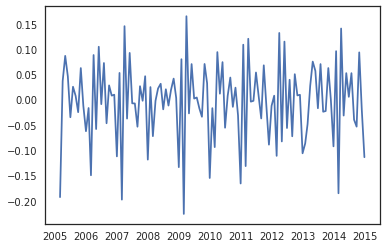

In [76]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

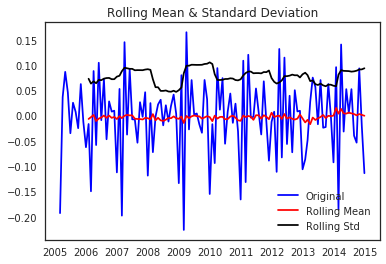

Results of Dickey-Fuller Test:
Test Statistic                  -2.837690
p-value                          0.053088
#Lags Used                      13.000000
Number of Observations Used    105.000000
Critical Value (10%)            -2.581676
Critical Value (5%)             -2.889485
Critical Value (1%)             -3.494220
dtype: float64


In [77]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

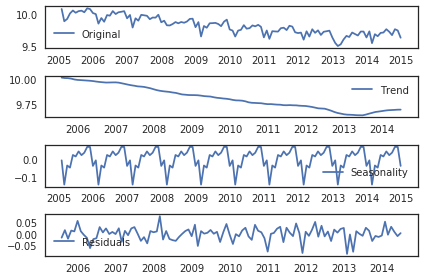

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

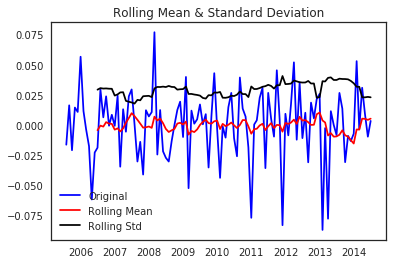

Results of Dickey-Fuller Test:
Test Statistic                 -4.090935
p-value                         0.001002
#Lags Used                     11.000000
Number of Observations Used    96.000000
Critical Value (10%)           -2.583100
Critical Value (5%)            -2.892152
Critical Value (1%)            -3.500379
dtype: float64


In [79]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [80]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [81]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

Text(0.5,1,'Autocorrelation Function')

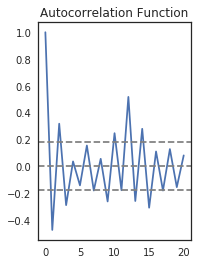

In [82]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

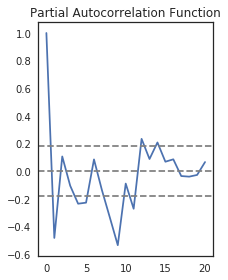

In [83]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [135]:
from statsmodels.tsa.arima_model import ARIMA, AR

RMSE: 699.8491


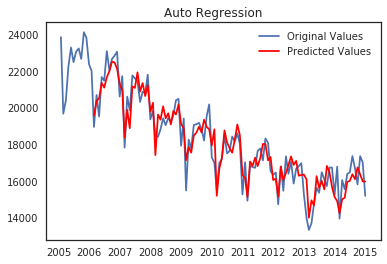

In [145]:
model = AR(ts)  
results_AR = model.fit(disp=-1)  
plt.plot(ts, label='Original Values')
plt.plot(results_AR.fittedvalues, color='red', label='Predicted Values')
plt.title('Auto Regression')
plt.legend()
print('RMSE: %.4f'% np.sqrt(sum((results_AR.fittedvalues-ts[13:])**2)/len(ts)))

RMSE: 1268.3957


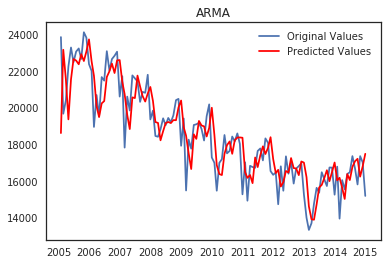

In [154]:
model2 = ARIMA(ts.astype('float64'), order=(2,0,1))  
results_ARMA = model2.fit(disp=-1)  
plt.plot(ts, label='Original Values')
plt.plot(results_ARMA.fittedvalues, color='red', label='Predicted Values')
plt.title('ARMA')
plt.legend()
print('RMSE: %.4f'% np.sqrt(sum((results_ARMA.fittedvalues-ts)**2)/len(ts)))

In [152]:
ts

convert_to_date
2005-01-31    23836
2005-02-28    19657
2005-03-31    20388
2005-04-30    22228
2005-05-31    23268
2005-06-30    22469
2005-07-31    23046
2005-08-31    23216
2005-09-30    22644
2005-10-31    24100
2005-11-30    23804
2005-12-31    22361
2006-01-31    21992
2006-02-28    18937
2006-03-31    20679
2006-04-30    19510
2006-05-31    21656
2006-06-30    21462
2006-07-31    23069
2006-08-31    22013
2006-09-30    22639
2006-10-31    22817
2006-11-30    23038
2006-12-31    20592
2007-01-31    21705
2007-02-28    17812
2007-03-31    20592
2007-04-30    19833
2007-05-31    21748
2007-06-30    21588
              ...  
2012-07-31    17042
2012-08-31    15850
2012-09-30    16666
2012-10-31    16803
2012-11-30    16962
2012-12-31    15253
2013-01-31    13986
2013-02-28    13323
2013-03-31    13689
2013-04-30    14756
2013-05-31    15617
2013-06-30    15351
2013-07-31    16467
2013-08-31    16076
2013-09-30    15716
2013-10-31    16727
2013-11-30    16719
2013-12-31    15243
2014

In [143]:
len(ts)

120

Text(0.5,1,'RSS: 0.5268')

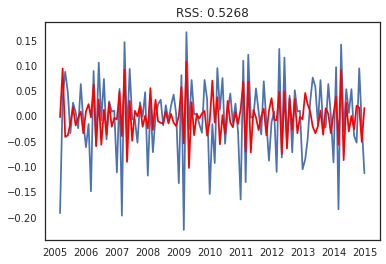

In [130]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_ARIMA = model.fit()  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [131]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

convert_to_date
2005-02-28   -0.003139
2005-03-31    0.092912
2005-04-30   -0.042052
2005-05-31   -0.039055
2005-06-30   -0.015197
Freq: M, dtype: float64


In [132]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

convert_to_date
2005-02-28   -0.003139
2005-03-31    0.089773
2005-04-30    0.047721
2005-05-31    0.008666
2005-06-30   -0.006531
Freq: M, dtype: float64


In [133]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

convert_to_date
2005-01-31    10.078952
2005-02-28    10.075814
2005-03-31    10.168725
2005-04-30    10.126673
2005-05-31    10.087618
Freq: M, dtype: float64

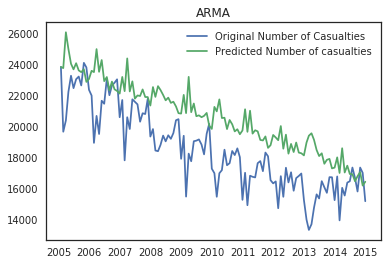

In [134]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts, label='Original Number of Casualties')
plt.plot(predictions_ARIMA, label='Predicted Number of casualties')
plt.title('ARMA')
plt.legend()

2673.44 (ARMA)
1123.9736 (Moving average)
1346.06 (EWMA)

In [ ]:
-